# Computer Vision Homework | MNIST

### Importing Necessary Packages

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import layers, models

### Importing Data

In [28]:
sample_submission = pd.read_csv('data/mnist/sample_submission.csv')
test = pd.read_csv('data/mnist/test.csv')
train = pd.read_csv('data/mnist/train.csv')

### Data Formatting

In [50]:
# extract the labels
labels = train.iloc[:, 0].values
# extract the features
features = train.iloc[:, 1:].values

#reshape each row to 28x28
features = features.reshape(features.shape[0], 28, 28)


### Initial Analysis

In [44]:
#small analysis of dataset
print(f"The train dataset containes {features.shape[0]} images.")
print(f"Each image has a size of {features.shape[1]}x{features.shape[2]}.\n")

print(f"The labels array has {labels.shape[0]} rows.\n")

print(f"The test dataset has {test.shape[0]} rows and {test.shape[1]} columns.")
print("That means it has 28000 images with 784 pixels each, the first column \
however it does not contain the labels.\n")

The train dataset containes 42000 images.
Each image has a size of 28x28.

The labels array has 42000 rows.

The test dataset has 28000 rows and 784 columns.
That means it has 28000 images with 784 pixels each, the first column however it does not contain the labels.



This is how a single image looks like:


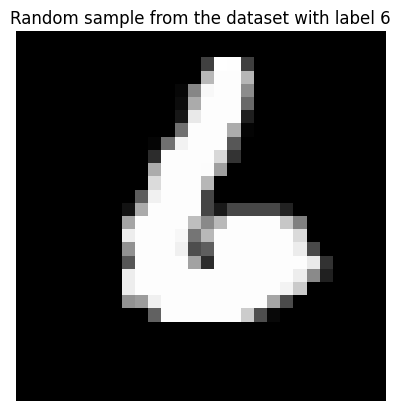

In [48]:
print("This is how a single image looks like:")
random_ind = random.randint(1,42000)
random_sample = features[random_ind]
label = labels[random_ind]
random_sample = random_sample.reshape((28, 28))

plt.imshow(random_sample, cmap='gray')
plt.axis('off')
plt.title(f"Random sample from the dataset with label {label}")
plt.show()

The number of samples per label is:
[4132 4684 4177 4351 4072 3795 4137 4401 4063 4188]


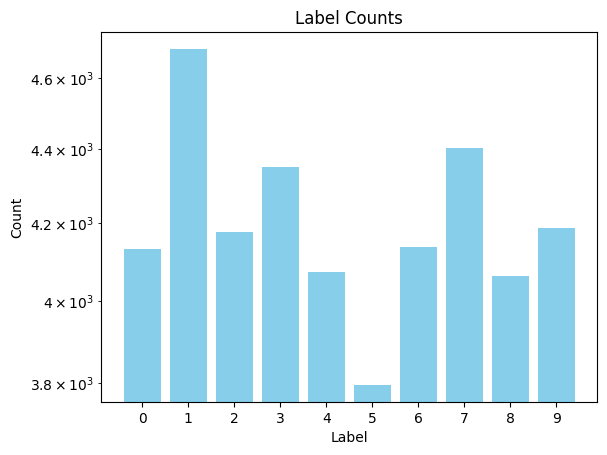

In [75]:
label_counts = np.unique(labels, return_counts=True)
print("The number of samples per label is:")
print(label_counts[1]) 

plt.bar(label_counts[0], label_counts[1], color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts')
plt.xticks(ticks=np.arange(10))
plt.yscale('log')
plt.show()

### Preprocessing

In [134]:
def preprocessing(features, labels):
    #expects grayscale images
    num_samples, image_rows, image_columns = features.shape
    # convert to float
    features = features.astype('float32')
    
    # reshape to 1 channel
    features = features.reshape(num_samples, image_rows, image_columns, 1)
    
    X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    # Split the temporary set into validation and test sets
    X_train, X_validation, y_train, y_validation = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)
    X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    #scaling
    scaler = StandardScaler()
    X_train = X_train.reshape((X_train.shape[0], image_rows * image_columns))
    X_validation = X_validation.reshape((X_validation.shape[0], image_rows * image_columns))
    X_test = X_test.reshape((X_test.shape[0], image_rows * image_columns))
    
    X_train = scaler.fit_transform(X_train)
    X_validation= scaler.transform(X_validation)
    X_test = scaler.transform(X_test)
    
    X_train = X_train.reshape((X_train.shape[0], image_rows, image_columns, 1))
    X_validation = X_validation.reshape((X_validation.shape[0], image_rows, image_columns, 1))
    X_test = X_test.reshape((X_test.shape[0], image_rows, image_columns, 1))

    return X_train, X_test, X_validation, y_train, y_test, y_validation

### Baseline Model

In [135]:
def baseline_model(X_train, X_test, X_validation, y_train, y_test, y_validation):
    dummy_classifier = DummyClassifier(strategy="most_frequent") #using "most frequent" strategy
    dummy_classifier.fit(X_train, y_train)

    y_val_pred = dummy_classifier.predict(X_validation)
    val_accuracy = accuracy_score(y_validation, y_val_pred)
    print(f"Accuracy on validation set: {val_accuracy:.4f}")
    
    y_pred = dummy_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy on test set: {accuracy:.4f}")

### Linear Model

In [123]:
def linear_model(X_train, X_test, X_validation, y_train, y_test, y_validation):
    num_samples, num_channels, height, width = X_train.shape
    X_train_flattened = X_train.reshape((num_samples, num_channels * height * width))
    num_samples_test, _, _, _ = X_test.shape
    X_test_flattened = X_test.reshape((num_samples_test, num_channels * height * width))
    X_validation_flattened = X_validation.reshape((X_validation.shape[0], num_channels * height * width))   
    
    
    logistic_regression = LogisticRegression(max_iter=1000, C=1)
    logistic_regression.fit(X_train_flattened, y_train)
    
    # Evaluate on the Validation Set
    y_val_pred = logistic_regression.predict(X_validation_flattened)
    val_accuracy = accuracy_score(y_validation, y_val_pred)
    print(f"Accuracy on validation set: {val_accuracy:.4f}")

    # Evaluate on the Test Set
    y_test_pred = logistic_regression.predict(X_test_flattened)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy on test set: {test_accuracy:.4f}")

### CNN

In [139]:
def cnn(X_train, X_test, X_validation, y_train, y_test, y_validation):
    #print(X_train[0])
    # Create a simple CNN model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))  # Output layer with 10 classes

    # Compile the model
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=5, validation_data=(X_validation, y_validation))
    
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    #evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

### Pipeline

In [141]:
def pipeline(features, labels):
    X_train, X_test, X_validation, y_train, y_test, y_validation = preprocessing(features, labels)
    print("-------------------")
    print("Baseline model:")
    baseline_model(X_train, X_test, X_validation, y_train, y_test, y_validation)
    print("-------------------")
    print("Linear model:")
    linear_model(X_train, X_test, X_validation, y_train, y_test, y_validation)
    print("-------------------")
    print("CNN model:")
    cnn(X_train, X_test, X_validation, y_train, y_test, y_validation)
    print("-------------------")

-------------------
Baseline model:
Accuracy on validation set: 0.1083
Accuracy on test set: 0.1081
-------------------
Linear model:
Accuracy on Validation Set: 0.8983
Accuracy on Test Set: 0.8990
-------------------
CNN model:
Epoch 1/5
788/788 [==============================] - 19s 22ms/step - loss: 0.2136 - accuracy: 0.9354 - val_loss: 0.0747 - val_accuracy: 0.9752
Epoch 2/5
788/788 [==============================] - 18s 23ms/step - loss: 0.0600 - accuracy: 0.9819 - val_loss: 0.0501 - val_accuracy: 0.9843
Epoch 3/5
788/788 [==============================] - 18s 23ms/step - loss: 0.0425 - accuracy: 0.9863 - val_loss: 0.0487 - val_accuracy: 0.9836
Epoch 4/5
788/788 [==============================] - 18s 23ms/step - loss: 0.0314 - accuracy: 0.9902 - val_loss: 0.0511 - val_accuracy: 0.9848
Epoch 5/5
788/788 [==============================] - 18s 23ms/step - loss: 0.0249 - accuracy: 0.9914 - val_loss: 0.0452 - val_accuracy: 0.9857


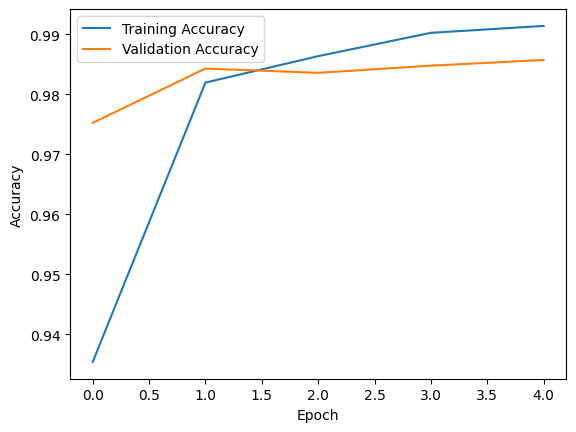

132/132 [==============================] - 1s 7ms/step - loss: 0.0506 - accuracy: 0.9855
Test Loss: 0.0506
Test Accuracy: 0.9855
-------------------


In [142]:
pipeline(features, labels)

### Data Loading

In [86]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Defining CNN

In [87]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) 
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # Output layer with 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### Setting Up Model

In [88]:
model = CNN() # instantiate the model
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # optimizer

### Training CNN

In [93]:
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.view(-1, 1, 28, 28)  # Reshape input to [batch_size, channels, height, width]
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [06:51<00:00, 41.18s/it]


### Evaluating CNN

In [95]:
model.eval()
with torch.no_grad():
    all_predictions = []
    for inputs, labels in test_loader:
        inputs = inputs.view(-1, 1, 28, 28)  # Reshape input to [batch_size, channels, height, width]
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.numpy())

### Calculating Accuracy

In [100]:
accuracy = accuracy_score(test_dataset.tensors[1].numpy(), all_predictions)
print(f"Accuracy of the model: {accuracy:.4f}")

Accuracy of the model: 0.9868


### Importing Packages For Transfer Learning

In [128]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

### Label Encoding

In [124]:
orig_labels = train['label']
y = tf.keras.utils.to_categorical(orig_labels) # one-hot encoding
train.drop('label', axis=1, inplace=True)
train.head(1)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Preparing Data

In [125]:
train_arr = np.array(train).reshape(-1, 28, 28, 1)
train_arr.shape

(42000, 28, 28, 1)

In [129]:
def change_size(image):
    img = array_to_img(image, scale=False) #returns PIL Image
    img = img.resize((75, 75)) #resize image
    img = img.convert(mode='RGB') #makes 3 channels
    arr = img_to_array(img) #convert back to array
    return arr.astype(np.float64)

In [130]:
train_arr_75 = [change_size(img) for img in train_arr] #resize all images
del train_arr
train_arr_75 = np.array(train_arr_75)
train_arr_75.shape

(42000, 75, 75, 3)

### Creating Generators

In [134]:
image_gen = ImageDataGenerator(rescale=1./255, #easier for network to interpret numbers in range [0,1]
                              zoom_range=0.1,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              validation_split=0.2) # 80/20 train/val split

train_generator = image_gen.flow(train_arr_75, 
                                 y,
                                batch_size=32,
                                shuffle=True,
                                subset='training',
                                seed=42)
valid_generator = image_gen.flow(train_arr_75,
                                 y,
                                batch_size=16,
                                shuffle=True,
                                subset='validation')
del train_arr_75 

### Importing Pretrained Model

In [135]:
model = Sequential()

model.add(tf.keras.applications.resnet50.ResNet50(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet'))

model.add(L.Flatten())
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(10, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Freezing Layers

In [136]:
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block1_0_conv':
        break
    layer.trainable=False

### Training

In [137]:
#WARNING: training takes very long
history = model.fit(train_generator, validation_data=valid_generator, epochs=5, 
          steps_per_epoch=train_generator.n//train_generator.batch_size,
         validation_steps=valid_generator.n//valid_generator.batch_size)

Epoch 1/5
1050/1050 [==============================] - 3785s 4s/step - loss: 0.1977 - accuracy: 0.9425 - val_loss: 0.3730 - val_accuracy: 0.8877
Epoch 2/5
1050/1050 [==============================] - 3491s 3s/step - loss: 0.0749 - accuracy: 0.9803 - val_loss: 0.0686 - val_accuracy: 0.9819
Epoch 3/5
1050/1050 [==============================] - 3250s 3s/step - loss: 0.0519 - accuracy: 0.9854 - val_loss: 0.0468 - val_accuracy: 0.9861
Epoch 4/5
1050/1050 [==============================] - 3236s 3s/step - loss: 0.0567 - accuracy: 0.9856 - val_loss: 0.0429 - val_accuracy: 0.9894
Epoch 5/5
1050/1050 [==============================] - 3238s 3s/step - loss: 0.0488 - accuracy: 0.9872 - val_loss: 0.0479 - val_accuracy: 0.9875


### Evaluating Model

In [138]:
evaluation = model.evaluate(valid_generator, steps=valid_generator.n // valid_generator.batch_size)

# 'evaluation' will contain the loss value and any additional metrics specified during model compilation
print("Validation Loss: {:.4f}".format(evaluation[0]))
print("Validation Accuracy: {:.2f}%".format(evaluation[1] * 100))

525/525 [==============================] - 217s 409ms/step - loss: 0.0485 - accuracy: 0.9868
Validation Loss: 0.0485
Validation Accuracy: 98.68%
